In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 6)

df = pd.read_csv("/content/student-mat.csv")
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
df.info()
print("\nКоличество пропусков по каждому признаку:")
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

,0
school,0
sex,0
age,0
address,0
famsize,0
Pstatus,0
Medu,0
Fedu,0
Mjob,0
Fjob,0


В датасете нет пропусков по признакам, поэтому дополнительная обработка пропущенных значений не требуется.

# EDA

## Визуализация

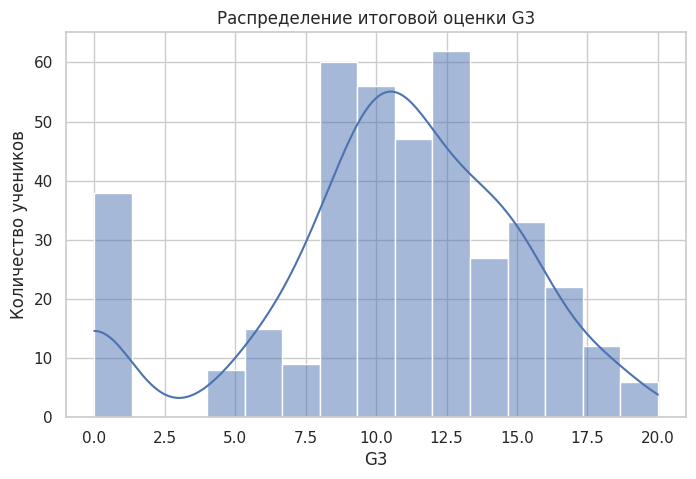

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(df["G3"], kde=True, bins=15)
plt.title("Распределение итоговой оценки G3")
plt.xlabel("G3")
plt.ylabel("Количество учеников")
plt.show()

Распределение близко к нормальглму, большинство получают оценки в районе 8-14 баллов.
Также есть и те кто получили по 0 баллов, а также и те кто получил наивысшие былла.

## Зависимости

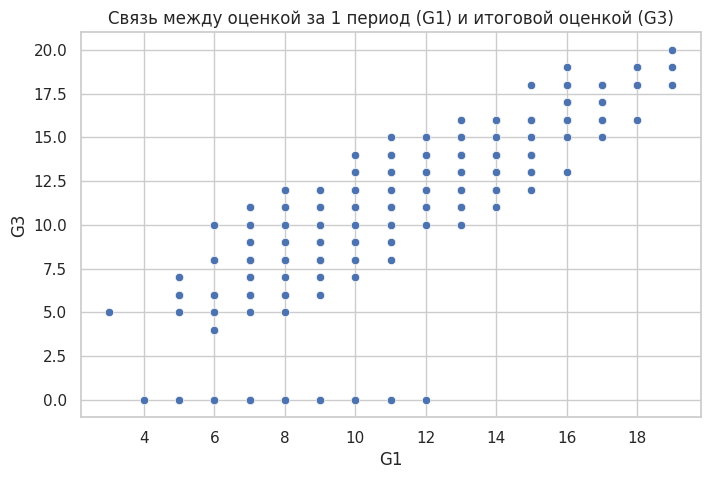

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="G1", y="G3", data=df)
plt.title("Связь между оценкой за 1 период (G1) и итоговой оценкой (G3)")
plt.xlabel("G1")
plt.ylabel("G3")
plt.show()

Мы видим положительную зависимость, чем выше оценка G1 тем выше итоговая оценка G3.
Точки сосредоточенны по диагонали.


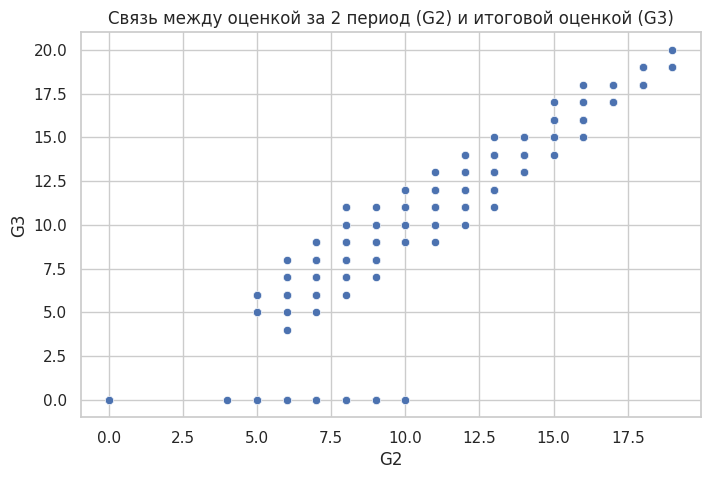

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="G2", y="G3", data=df)
plt.title("Связь между оценкой за 2 период (G2) и итоговой оценкой (G3)")
plt.xlabel("G2")
plt.ylabel("G3")
plt.show()

Зависимость между G2 и G3 еще сильнее, так как точки расположенны к диагонали ближе.
Это нам говорит о высокой корреляции между оценкой за второй период и итоговой оценкой.

## Корреляционная матрица

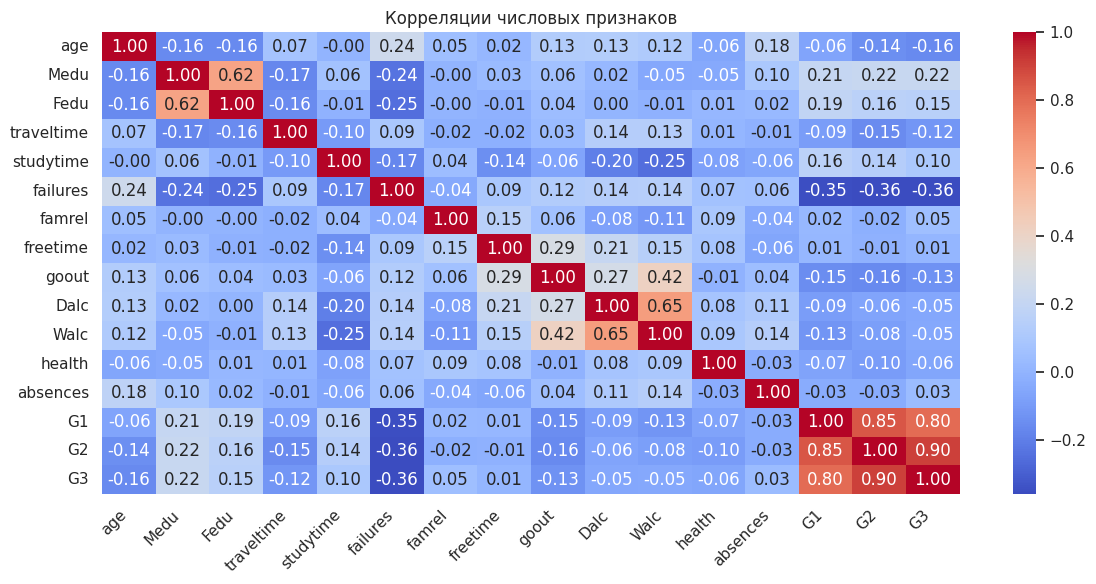

,G3
G3,1.000000
G2,0.904868
G1,0.801468
Medu,0.217147
Fedu,0.152457
studytime,0.097820
famrel,0.051363
absences,0.034247
freetime,0.011307
Walc,-0.051939


In [ ]:
plt.figure(figsize=(12,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции числовых признаков")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

corr["G3"].sort_values(ascending=False)

G3 имеет сильную положительную корреляцию с G2. Также G3 имеет положительную корреляцию с G1.
Наиболее сильные положительные корреляции с целевой переменной G3 наблюдаются у признаков, Medu, Fedu но они имеет слабую положительную связь.

Сильная отрицательная связь c failures чем больше провалов, тем ниже итоговая оценка.


## Аномалии

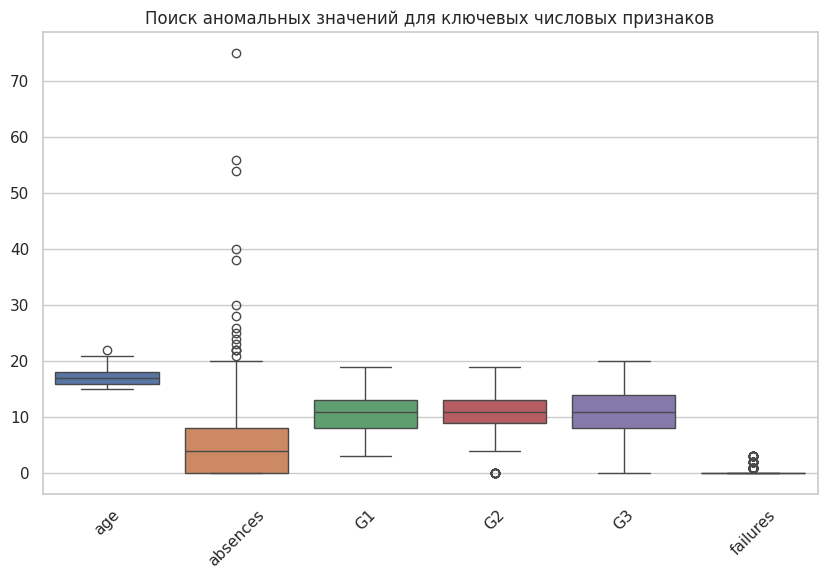

In [ ]:
cols = ["age", "absences", "G1", "G2", "G3", "failures"]
plt.figure(figsize=(10,6))
sns.boxplot(data=df[cols])
plt.title("Поиск аномальных значений для ключевых числовых признаков")
plt.xticks(rotation=45)
plt.show()

- absences - есть выбросы
- G1, G2, G3 — распределения более компактные.
- failures — большинство учеников не имеют провалов, но все же есть небольшая группа с 2–3 неудачами.

## Дубликаты

In [ ]:
df.duplicated().sum()

np.int64(0)

Дубликатов строк в датасете нет.

## Типы данных

In [ ]:
df.dtypes

,0
school,object
sex,object
age,int64
address,object
famsize,object
Pstatus,object
Medu,int64
Fedu,int64
Mjob,object
Fjob,object


Часть признаков хранится как числовые (`int64`), напримаер оценки G1, G2, G3.
Другая часть признаков являются категориальными и имеют тип object

# Модели

In [ ]:
# Целевая переменная и матрица признаков
y = df["G3"]
X = df.drop("G3", axis=1)

# One-hot кодирование категориальных признаков
X = pd.get_dummies(X, drop_first=True)

# Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X.shape, X_train.shape, X_test.shape

((395, 41), (316, 41), (79, 41))

# Модель 1
Линейная регрессия

In [ ]:
model1 = LinearRegression()
model1.fit(X_train, y_train)
pred1 = model1.predict(X_test)

print("R2:", r2_score(y_test, pred1))
print("MSE:", mean_squared_error(y_test, pred1))

R2: 0.7241341236974022
MSE: 5.656642833231222


Линейная регрессия показывает плохое качество:

R² = 0.72 - модель объясняет 72% дисперсии целевой переменной

MSE = 5.66 - средняя ошибка предсказания составляет около 5.66 балла


# Модель 2
Дерево решений

In [ ]:
model2 = DecisionTreeRegressor(max_depth=5, random_state=42)
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)

print("R2:", r2_score(y_test, pred2))
print("MSE:", mean_squared_error(y_test, pred2))

R2: 0.7031308891822728
MSE: 6.087315149746224


Decision Tree показывает результат хуже по сравнению с линейной регрессией:



R² = 0.70 - модель объясняет 70% дисперсии целевой переменной

MSE = 6.1 - средняя ошибка предсказания составляет около 6 балла

Модель требует настройки гиперпараметров или выбора другого алгоритма.

# Модель 3
Случайный лес

In [ ]:
model3 = RandomForestRegressor(n_estimators=200, random_state=42)
model3.fit(X_train, y_train)
pred3 = model3.predict(X_test)

print("R2:", r2_score(y_test, pred3))
print("MSE:", mean_squared_error(y_test, pred3))

R2: 0.8113810489794643
MSE: 3.8676405063291144


Random Forest показывает лучшее качество:

R² = 0.81 - модель объясняет 81% дисперсии целевой переменной

MSE = 3.87 - средняя ошибка предсказания составляет около 3.87 балла

Модель работает лучше чем остальные.

# Модель 4
Градиентный бустинг

In [ ]:
model4 = GradientBoostingRegressor(random_state=42)
model4.fit(X_train, y_train)
pred4 = model4.predict(X_test)

print("R2:", r2_score(y_test, pred4))
print("MSE:", mean_squared_error(y_test, pred4))

R2: 0.8040117686390182
MSE: 4.01874794804159


Gradient Boosting показывает среднее качество:

R² = 0.80 - модель объясняет 73% дисперсии целевой переменной

MSE = 4.01 - средняя ошибка предсказания составляет около 4.01 балла

Случайный лес и градиентный бустинг, дают более высокое качество предсказания за счёт комбинации множества деревьев.